## Introduction

### Description

This notebook demonstrates how to **detect and mask transient (impulsive) noise** in echosounder data using **echopype**.  
The workflow is inspired by approaches from [**echopy**](https://github.com/open-ocean-sounding/echopy) and [**Matecho**](https://forge.ird.fr/lemar/active_acoustics/matecho).

We open raw **EK60** data, convert to a portable format, add a depth coordinate, then compute transient-noise masks with built-in methods (e.g., **fielding**, **matecho**) and apply them to clean the echogram.

### Outline

1) [Open and convert raw echosounder data](#open-and-convert-raw-echosounder-data)  
2) [Apply transient noise filtering](#apply-transient-noise-filtering)  
3) [Show results on 38 kHz with profiles](#show-results-on-38-khz-with-profiles)

### Running the notebook

Use the conda environment in [`conda/environment-ep-main.yml`](../conda/environment-ep-main.yml).  
Example files are under `notebooks/example_data/transient_noise/`.  
Data courtesy of the British Antarctic Survey (BAS) RapidKrill archive (ftp://ftp.bas.ac.uk/rapidkrill/).

### Note

We encourage importing Echopype as `ep` for consistency.


### Open and convert raw echosounder data

In [1]:
import echopype as ep
import xarray as xr
import matplotlib.pyplot as plt

ed = ep.open_raw("./example_data/transient_noise/JR161-D20061118-T010645.raw", sonar_model="EK60", storage_options={"anon": True})
ed.to_zarr("./example_data/transient_noise/JR161-D20061118-T010645.zarr", overwrite="w")

Open converted file, and compute Sv.

In [2]:
ed = ep.open_converted("./example_data/transient_noise/JR161-D20061118-T010645.zarr")
ds_Sv = ep.calibrate.compute_Sv(ed, waveform_mode="CW", encode_mode="power")
ds_Sv = ep.consolidate.add_depth(ds_Sv, depth_offset=5.76) # put 5.76 is an example, as I do not know real value, could leave at 0

We inspect some variable sizes and dimensions.

In [3]:
ds_Sv["channel"].values  

array(['GPT  38 kHz 009072033fa5 1 ES38',
       'GPT 120 kHz 00907203422d 1 ES120-7',
       'GPT 200 kHz 009072033f91 1 ES200-7'], dtype='<U34')

In [4]:
ch = "GPT  38 kHz 009072033fa5 1 ES38"

da = ds_Sv["Sv"].sel(channel=ch, drop=True)          # Sv for one channel
depth = ds_Sv["depth"].sel(channel=ch, drop=True)    # depth for one channel

print("Sv dims:", da.dims)
print("Sv sizes:", da.sizes)
print("depth dims:", depth.dims)
print("depth sizes:", depth.sizes)

n_pings   = da.sizes["ping_time"]
n_ranges  = da.sizes["range_sample"]
print("Number of pings:", n_pings)
print("Number of samples per ping:", n_ranges)

if ("range_sample" in depth.dims) and (depth.ndim == 1):
    print("Depth vector length (1D):", depth.sizes["range_sample"])
elif depth.ndim == 2 and ("ping_time" in depth.dims) and ("range_sample" in depth.dims):
    print("Depth grid shape (2D):", {k: depth.sizes[k] for k in depth.dims})
    print("Depth along first ping:", depth.isel(ping_time=0).sizes["range_sample"])


Sv dims: ('ping_time', 'range_sample')
Sv sizes: Frozen({'ping_time': 403, 'range_sample': 5377})
depth dims: ('ping_time', 'range_sample')
depth sizes: Frozen({'ping_time': 403, 'range_sample': 5377})
Number of pings: 403
Number of samples per ping: 5377
Depth grid shape (2D): {'ping_time': 403, 'range_sample': 5377}
Depth along first ping: 5377


We then plot the data.

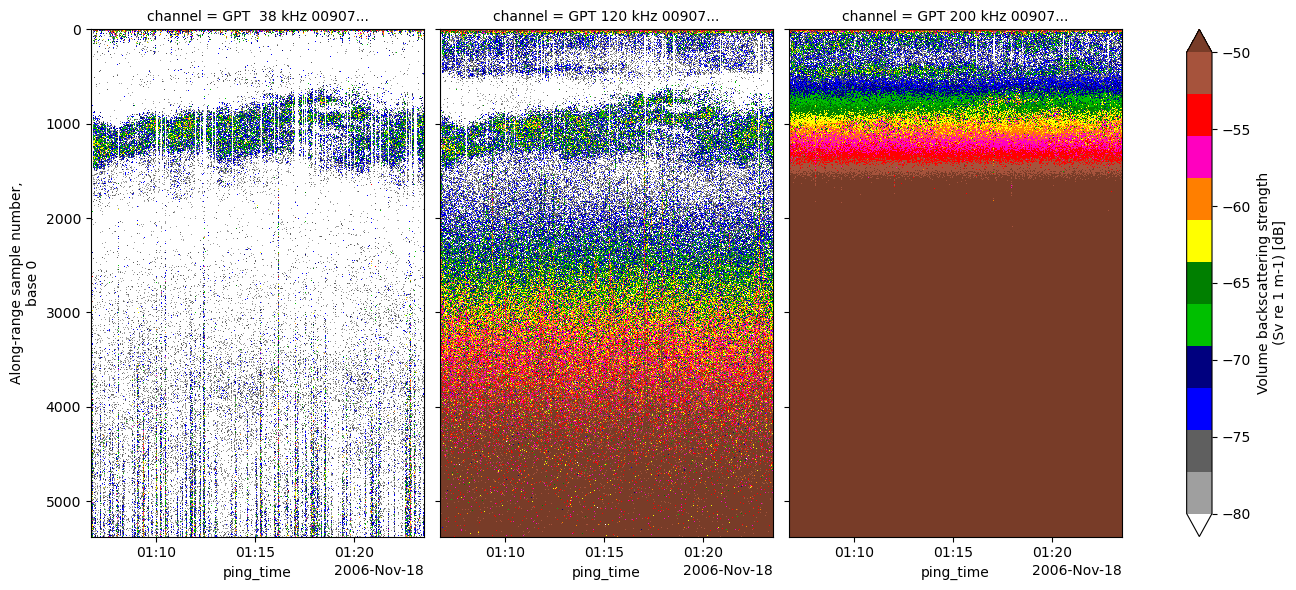

In [5]:
import matplotlib as mpl
import echopype.colormap

ds_Sv["Sv"].plot(
    x="ping_time",
    y="range_sample",
    row="channel", col_wrap=3,
    vmin=-80, vmax=-50,
    cmap=mpl.colormaps["ep.ek500"],
    yincrease=False,
    figsize=(14, 6),
)
plt.show()

We make a deep copy of the dataset (`deep=True`) to ensure the original remains unchanged.  
Then we trim each channel to its maximum usable depth range.


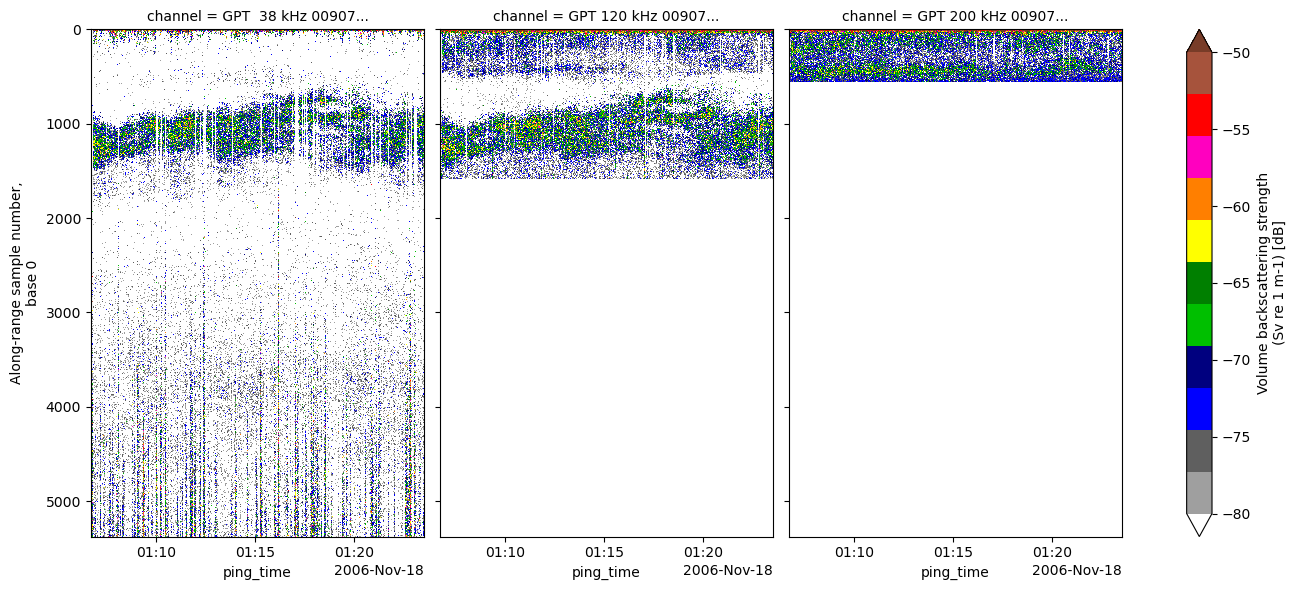

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Work on a completely independent copy (deep = True)
ds_Sv_trimmed = ds_Sv.copy(deep=True)

depth = ds_Sv_trimmed["depth"]   # dims: (channel, ping_time, range_sample)
Sv    = ds_Sv_trimmed["Sv"]

# Per-channel depth cutoffs (keep shallower than or equal to cutoff)
cutoffs = {
    "GPT 120 kHz 00907203422d 1 ES120-7": 300,  # keep <= 300 m
    "GPT 200 kHz 009072033f91 1 ES200-7": 110,  # keep <= 110 m
}

for ch_name, cutoff in cutoffs.items():
    if ch_name not in depth["channel"].values:
        print(f"[warn] channel not found: {ch_name}")
        continue
    # Per-channel depth mask (True = keep)
    keep_mask = (depth.sel(channel=ch_name) <= cutoff)
    # Apply to Sv for that channel (coords align by ping_time, range_sample)
    ds_Sv_trimmed["Sv"].loc[dict(channel=ch_name)] = (
        Sv.sel(channel=ch_name).where(keep_mask)
    )

# Plot result (per channel)
ds_Sv_trimmed["Sv"].plot(
    x="ping_time",
    y="range_sample",
    row="channel", col_wrap=3,
    vmin=-80, vmax=-50,
    cmap=mpl.colormaps["ep.ek500"],
    yincrease=False,
    figsize=(14, 6),
)
plt.show()


### Apply transient noise filtering

We next apply the Fielding method, presented here: link echopy

In [7]:
from echopype.clean import detect_transient

mask_fielding = detect_transient(
    ds=ds_Sv_trimmed,
    method="fielding",
    params={
        "var_name": "Sv",
        "range_var": "depth",
        "r0": 900,
        "r1": 1000,
        "n": 10,
        "thr": (3, 1),
        "roff": 20,
        "jumps": 5,
        "maxts": -35,
        "start": 0,
    },
)

We plot the boolean mask per channel. True (white) = kept (valid data), False (black) = removed (transient noise).

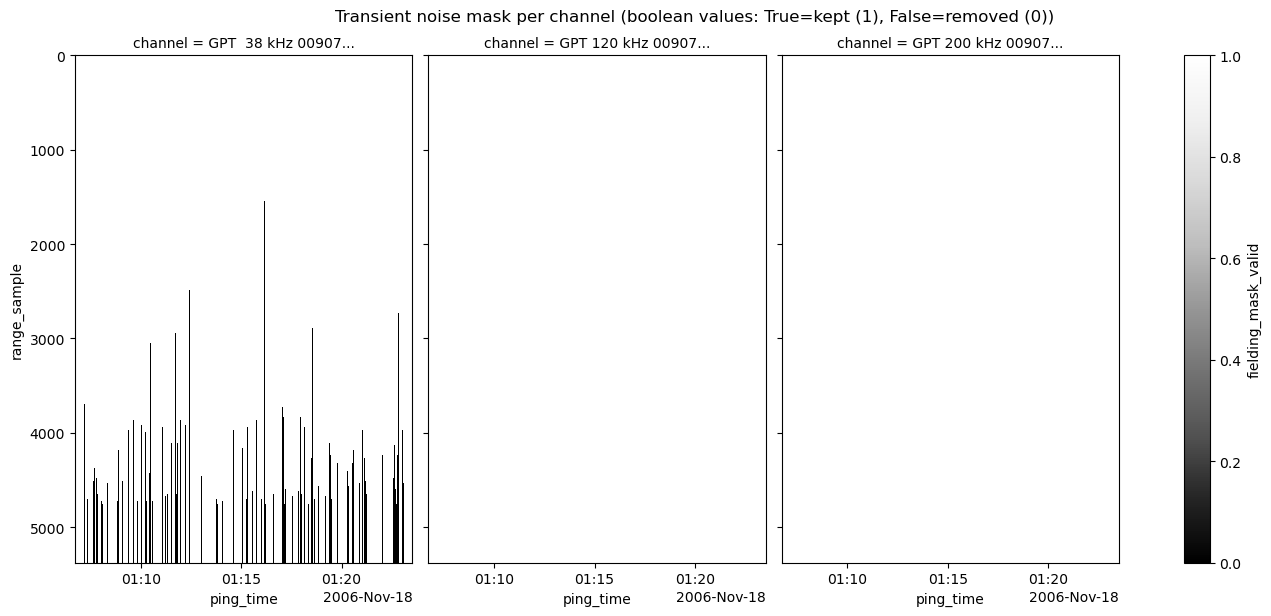

In [8]:
import matplotlib.pyplot as plt

g = mask_fielding.plot.pcolormesh(
    x="ping_time",
    y="range_sample",
    col="channel",
    col_wrap=3,
    yincrease=False,
    cmap="Greys_r",  # use reversed for clarity
    figsize=(14, 6),
)

g.fig.suptitle(
    "Transient noise mask per channel (boolean values: True=kept (1), False=removed (0))",
    y=1.02
)
plt.show()

We mask the data with apply_mask().

In [9]:
from echopype.mask import apply_mask
import numpy as np

ds_masked = apply_mask(
    ds_Sv_trimmed,
    mask_fielding,
    var_name="Sv",
    fill_value=np.nan
)

We then plot the masked data.

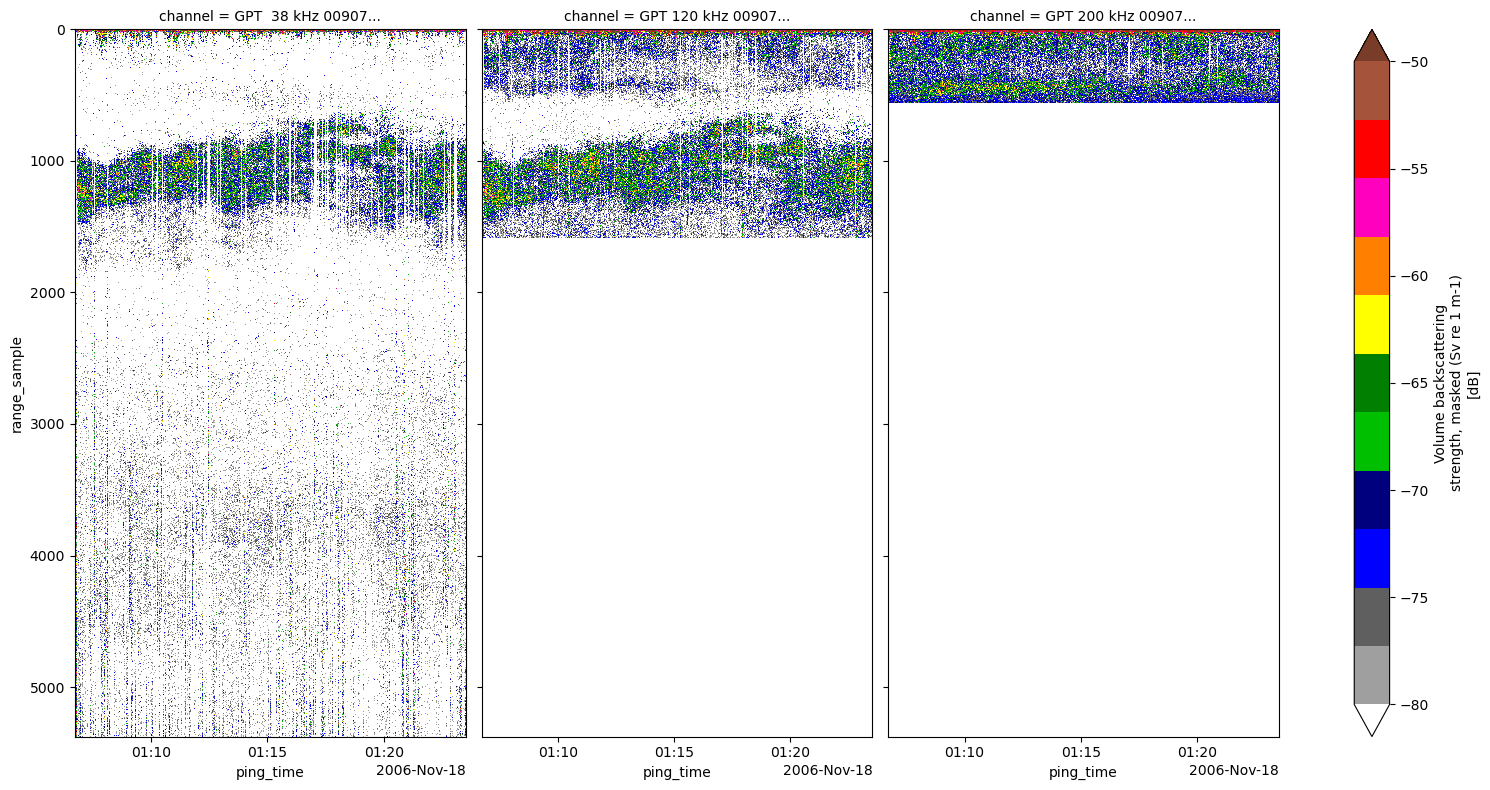

In [10]:
import matplotlib as mpl

ds_masked["Sv"].plot(
    x="ping_time",
    row="channel", col_wrap=3,
    vmin=-80, vmax=-50,
    cmap=mpl.colormaps["ep.ek500"],
    yincrease=False,
    figsize=(16, 8)
)


We then compare with the method referred to here as `matecho`.

In [11]:
mask_matecho = detect_transient(
    ds=ds_Sv_trimmed,
    method="matecho",
    params={
        "var_name": "Sv",
        "range_var": "depth",
        "bottom_var": None,
        "start_depth": 700,
        "window_meter": 300,
        "window_ping": 50,
        "percentile": 25,
        "delta_db": 8,
        "extend_ping": 0,
        "min_window": 5,
    },
)

We plot the boolean mask.

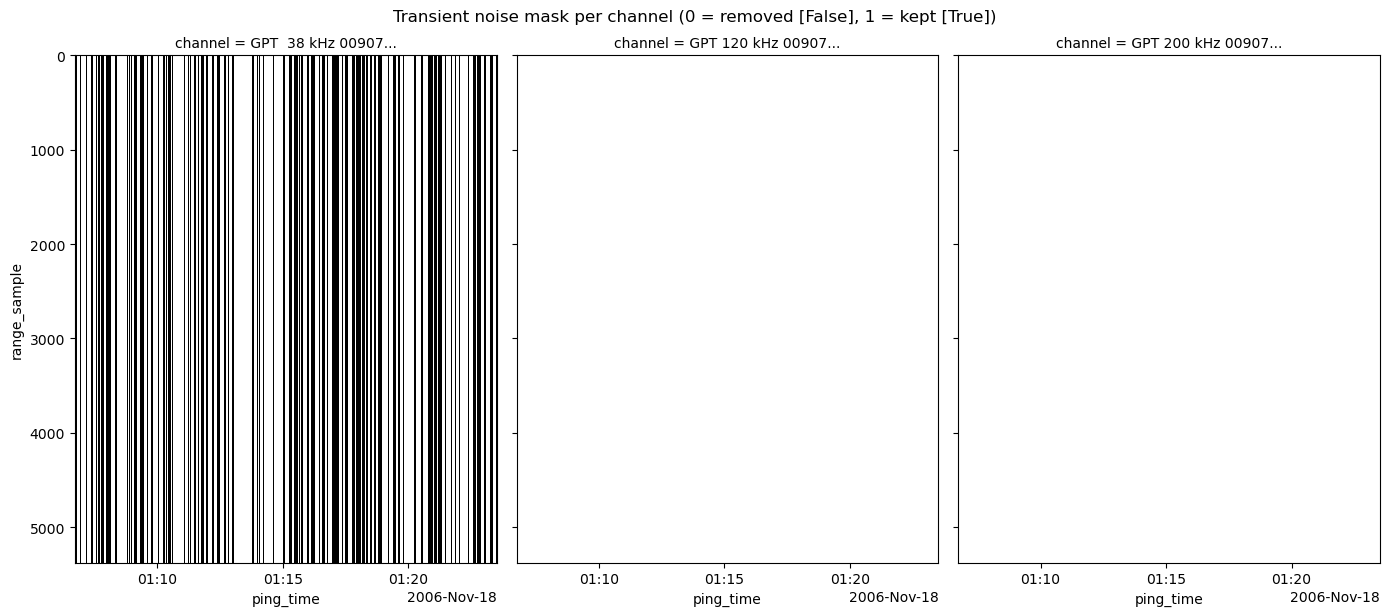

In [12]:
# Convert boolean mask to integers: False=0, True=1
mask_matecho_int = mask_matecho.astype(int)

g = mask_matecho_int.plot.pcolormesh(
    x="ping_time",
    y="range_sample",
    col="channel",
    col_wrap=3,
    yincrease=False,
    cmap="Greys_r",
    figsize=(14, 6),
    add_colorbar=False
)

g.fig.suptitle(
    "Transient noise mask per channel (0 = removed [False], 1 = kept [True])",
    y=1.02
)

plt.show()

We then apply the mask, and plot the masked data.

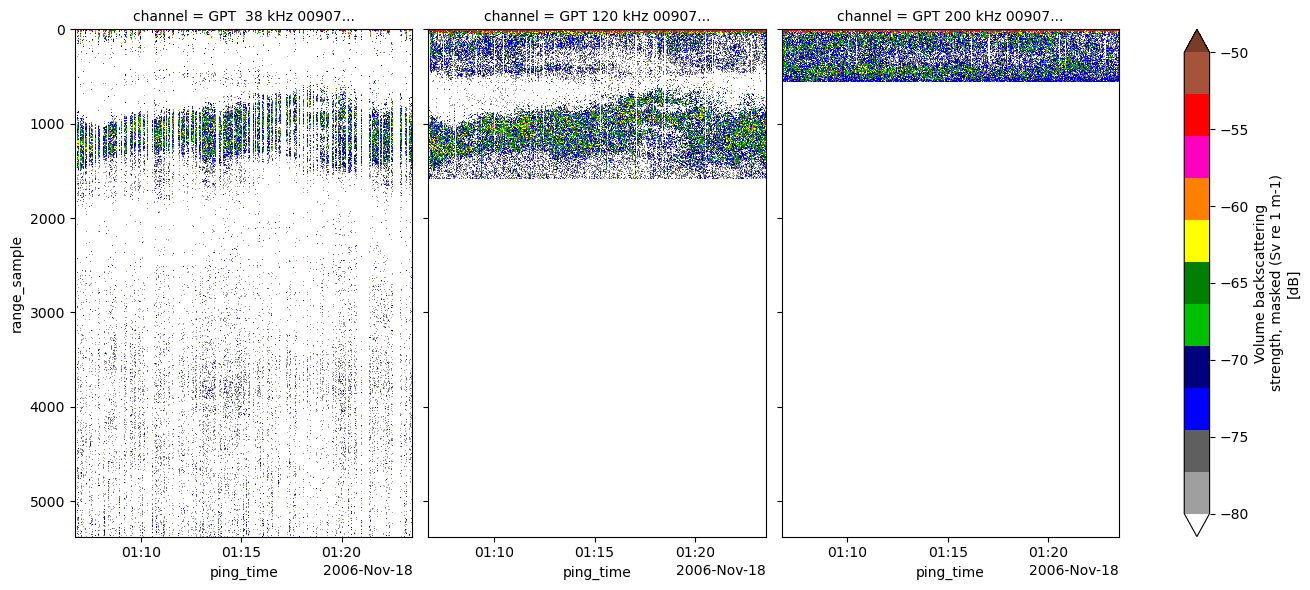

In [13]:
ds_masked = apply_mask(
    source_ds=ds_Sv_trimmed,
    mask=mask_matecho,
    var_name="Sv",
    fill_value=np.nan,
)

ds_masked["Sv"].plot(
    x="ping_time",
    y="range_sample",
    col="channel",
    col_wrap=3,
    vmin=-80, vmax=-50,
    cmap=mpl.colormaps.get("ep.ek500", mpl.colormaps["viridis"]),
    yincrease=False,
    figsize=(14, 6),
)
plt.show()

### Show results on 38 kHz with profiles

Using both mean and median profiles provides complementary insights: the median is robust to occasional spikes, while the mean highlights the extent to which energetic transients bias the original profiles.

In [ ]:
# pick the 38 kHz channel
ch38 = "GPT  38 kHz 009072033fa5 1 ES38"

# 1D coords
t = ds_Sv["ping_time"].values
r = ds_Sv["depth"].sel(channel=ch38).isel(ping_time=0).values

# Sv (ping, range) for RAW and MASKED
Sv_raw    = ds_Sv_trimmed["Sv"].sel(channel=ch38).transpose("ping_time", "range_sample").values
Sv_masked = ds_masked["Sv"].sel(channel=ch38).transpose("ping_time", "range_sample").values

# Transient-noise mask for the "MASK ONLY" panel:
# use the VALID mask directly (True=kept, False=removed)
# transpose to (range, ping) for plotting
mask_valid_rp = (
    mask_matecho.sel(channel=ch38)
    .transpose("range_sample", "ping_time")
)

mask_valid_rp_int = mask_valid_rp.astype(int)  # 0=removed [False], 1=kept [True]

Plot raw and masked echograms and profiles.

C:\Users\lloyd\AppData\Local\Temp\ipykernel_11324\2217471663.py:11: RuntimeWarning: Mean of empty slice
  m_lin = np.nanmean(Sv_lin, axis=0)
C:\Users\lloyd\AppData\Local\Temp\ipykernel_11324\2217471663.py:16: RuntimeWarning: All-NaN slice encountered
  m_lin = np.nanmedian(Sv_lin, axis=0)


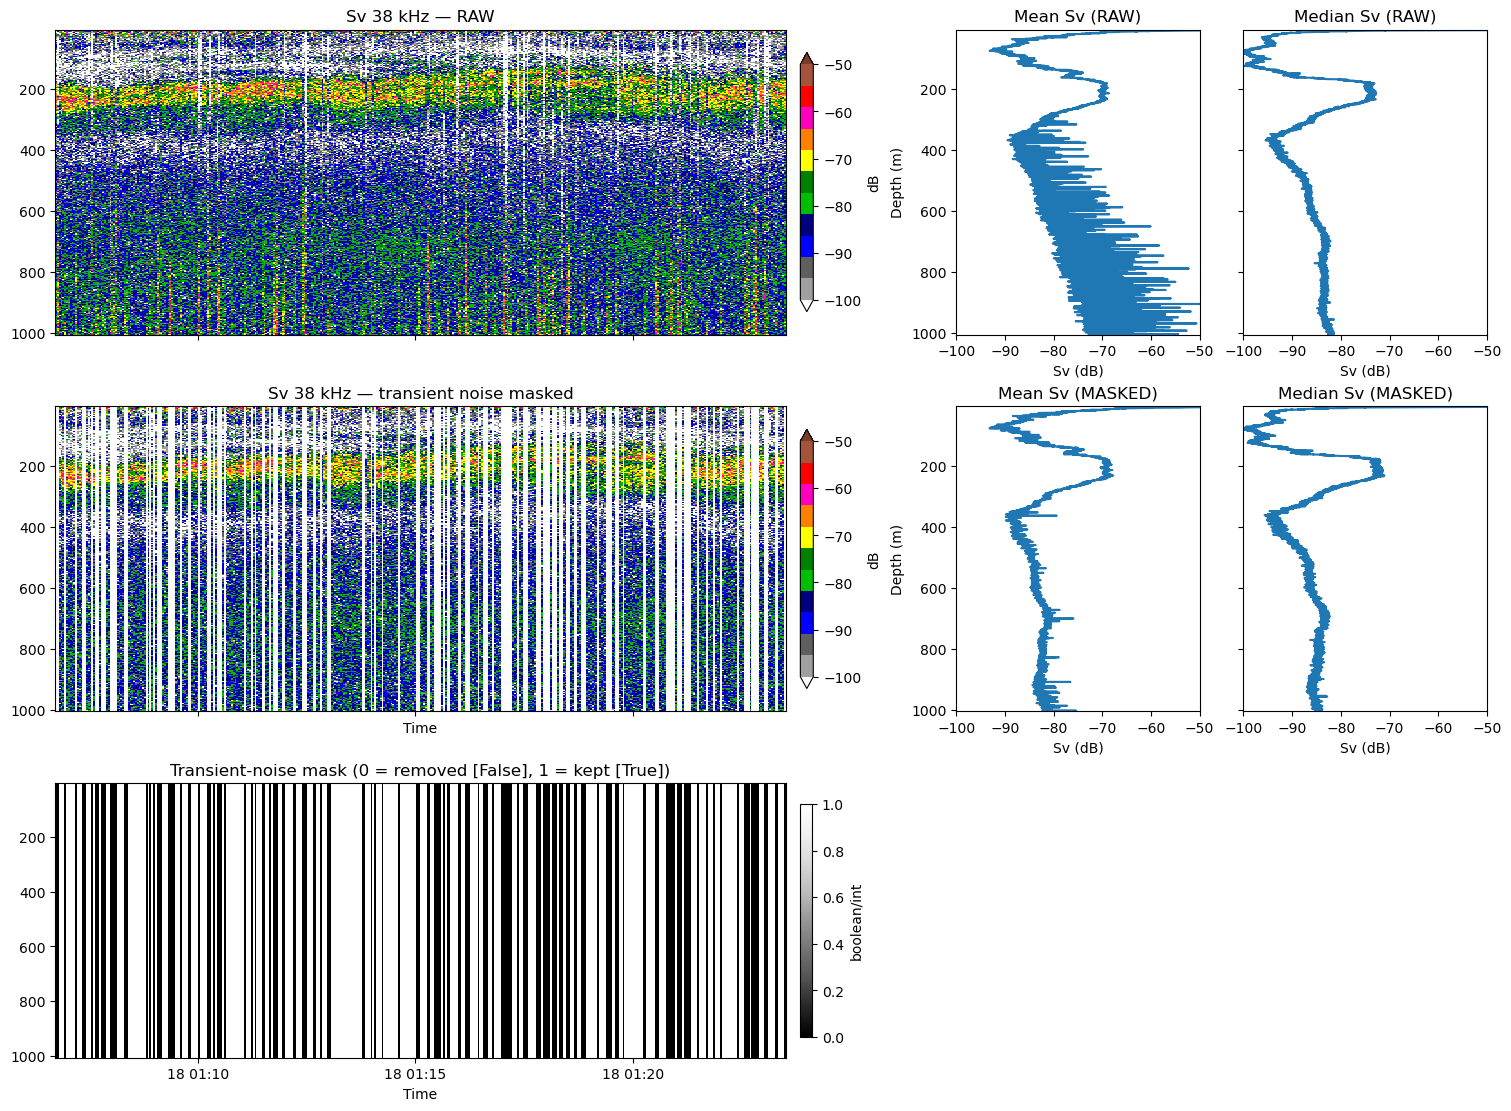

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# ---- helpers
def _masked(ZT):
    return np.ma.array(ZT, mask=~np.isfinite(ZT))

def profile_mean_db_over_time(Sv_db):
    Sv_lin = 10.0 ** (Sv_db / 10.0)
    m_lin = np.nanmean(Sv_lin, axis=0)
    return 10.0 * np.log10(m_lin)

def profile_median_db_over_time(Sv_db):
    Sv_lin = 10.0 ** (Sv_db / 10.0)
    m_lin = np.nanmedian(Sv_lin, axis=0)
    return 10.0 * np.log10(m_lin)

# ---- prep
C_raw    = _masked(Sv_raw.T)       # (range, ping)
C_masked = _masked(Sv_masked.T)

prof_raw_mean     = profile_mean_db_over_time(Sv_raw)
prof_raw_median   = profile_median_db_over_time(Sv_raw)
prof_mask_mean    = profile_mean_db_over_time(Sv_masked)
prof_mask_median  = profile_median_db_over_time(Sv_masked)

cmap_ek = mpl.colormaps["ep.ek500"]
vmin, vmax = -100, -50

# plot
fig = plt.figure(figsize=(15, 11), constrained_layout=True)
gs = fig.add_gridspec(
    nrows=3, ncols=3, figure=fig,
    width_ratios=[3.3, 1.1, 1.1],
    height_ratios=[1.0, 1.0, 0.9]
)

# ===== Row 1: RAW data
ax11 = fig.add_subplot(gs[0, 0])
ax12 = fig.add_subplot(gs[0, 1], sharey=ax11)
ax13 = fig.add_subplot(gs[0, 2], sharey=ax11)

im11 = ax11.pcolormesh(t, r, C_raw, vmin=vmin, vmax=vmax, cmap=cmap_ek, shading='auto')
ax11.invert_yaxis()
ax11.set_title('Sv 38 kHz — RAW')
ax11.tick_params(labelbottom=False)
cb11 = fig.colorbar(im11, ax=ax11, orientation='vertical', shrink=0.85, pad=0.02, extend='both')
cb11.set_label('dB')

ax12.plot(prof_raw_mean, r, lw=1.5)
ax12.invert_yaxis()
ax12.set_title('Mean Sv (RAW)')
ax12.set_xlabel('Sv (dB)')
ax12.set_ylabel('Depth (m)')

ax13.plot(prof_raw_median, r, lw=1.5)
ax13.invert_yaxis()
ax13.set_title('Median Sv (RAW)')
ax13.set_xlabel('Sv (dB)')
ax13.tick_params(labelleft=False)

# ===== Row 2: MASKED data
ax21 = fig.add_subplot(gs[1, 0], sharex=ax11, sharey=ax11)
ax22 = fig.add_subplot(gs[1, 1], sharey=ax11)
ax23 = fig.add_subplot(gs[1, 2], sharey=ax11)

im21 = ax21.pcolormesh(t, r, C_masked, vmin=vmin, vmax=vmax, cmap=cmap_ek, shading='auto')
ax21.invert_yaxis()
ax21.set_title('Sv 38 kHz — transient noise masked')
ax21.tick_params(labelbottom=False)
cb21 = fig.colorbar(im21, ax=ax21, orientation='vertical', shrink=0.85, pad=0.02, extend='both')
cb21.set_label('dB')

ax22.plot(prof_mask_mean, r, lw=1.5)
ax22.invert_yaxis()
ax22.set_title('Mean Sv (MASKED)')
ax22.set_xlabel('Sv (dB)')
ax22.set_ylabel('Depth (m)')

ax23.plot(prof_mask_median, r, lw=1.5)
ax23.invert_yaxis()
ax23.set_title('Median Sv (MASKED)')
ax23.set_xlabel('Sv (dB)')
ax23.tick_params(labelleft=False)

# ===== Row 3: MASK only
ax31 = fig.add_subplot(gs[2, 0], sharex=ax11, sharey=ax11)
ax32 = fig.add_subplot(gs[2, 1]); ax32.axis('off')
ax33 = fig.add_subplot(gs[2, 2]); ax33.axis('off')

mask_valid_rp_int = (
    mask_matecho.sel(channel=ch38)
    .transpose("range_sample", "ping_time")
    .astype(int)   # 0 = removed [False], 1 = kept [True]
)

im31 = ax31.pcolormesh(t, r, mask_valid_rp_int.values, cmap='Greys_r', shading='auto')
ax31.invert_yaxis()
ax31.set_title('Transient-noise mask (0 = removed [False], 1 = kept [True])')
cb31 = fig.colorbar(im31, ax=ax31, orientation='vertical', shrink=0.85, pad=0.02)
cb31.set_label('boolean/int')

# ---- consistent limits between all echograms and profiles
ax11.set_ylim(r.max(), r.min())
for axp in (ax12, ax13, ax22, ax23):
    axp.set_xlim(vmin, vmax)

ax21.set_xlabel('Time')
ax31.set_xlabel('Time')

plt.show()

In [16]:
import datetime
print(f"echopype: {ep.__version__}, xarray: {xr.__version__}")

print(f"\n{datetime.datetime.utcnow()} +00:00")

echopype: 0.10.2.dev12+gcb25040.d20250808, xarray: 2025.6.1

2025-10-01 13:25:24.948488 +00:00
